#Import dataset from drive (Zip File)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/Frood_Drive/D_18_Plus.zip

Streaming output truncated to the last 5000 lines.
  inflating: D_18/Spoil Sawi/9_62400.jpg  
  inflating: D_18/Spoil Sawi/9_62401.jpg  
  inflating: D_18/Spoil Sawi/9_62402.jpg  
  inflating: D_18/Spoil Sawi/9_62403.jpg  
  inflating: D_18/Spoil Sawi/9_62404.jpg  
  inflating: D_18/Spoil Sawi/9_62405.jpg  
  inflating: D_18/Spoil Sawi/9_62498.jpg  
  inflating: D_18/Spoil Sawi/9_62499.jpg  
  inflating: D_18/Spoil Sawi/9_62500.jpg  
  inflating: D_18/Spoil Sawi/9_62501.jpg  
  inflating: D_18/Spoil Sawi/9_62502.jpg  
  inflating: D_18/Spoil Sawi/9_62503.jpg  
  inflating: D_18/Spoil Sawi/9_62504.jpg  
  inflating: D_18/Spoil Sawi/9_62505.jpg  
  inflating: D_18/Spoil Sawi/9_62506.jpg  
  inflating: D_18/Spoil Sawi/9_62507.jpg  
  inflating: D_18/Spoil Sawi/9_62508.jpg  
  inflating: D_18/Spoil Sawi/9_62509.jpg  
  inflating: D_18/Spoil Sawi/9_62510.jpg  
  inflating: D_18/Spoil Sawi/9_62511.jpg  
  inflating: D_18/Spoil Sawi/9_62512.jpg  
  inflating: D_18/Spoil Sawi/9_62513.jpg  
  i

#Main process

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_18',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_18',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 31587 files belonging to 18 classes.
Using 25270 files for training.
Found 31587 files belonging to 18 classes.
Using 6317 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [6]:
class_names = train_dataset.class_names

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset).numpy())
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset).numpy())

Number of training batches: 790
Number of validation batches: 99
Number of test batches: 99


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

IMG_SHAPE = (224,224) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
base_model.trainable = False

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [11]:
prediction_layer = tf.keras.layers.Dense(18, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [14]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

99/99 [==============================] - 14s 66ms/step - loss: 3.2774 - accuracy: 0.0991
initial loss: 3.28
initial accuracy: 0.10


In [15]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
790/790 [==============================] - 64s 77ms/step - loss: 1.1690 - accuracy: 0.6542 - val_loss: 0.4416 - val_accuracy: 0.8958
Epoch 2/10
790/790 [==============================] - 56s 70ms/step - loss: 0.3850 - accuracy: 0.8964 - val_loss: 0.2549 - val_accuracy: 0.9416
Epoch 3/10
790/790 [==============================] - 57s 72ms/step - loss: 0.2584 - accuracy: 0.9274 - val_loss: 0.1873 - val_accuracy: 0.9568
Epoch 4/10
790/790 [==============================] - 55s 70ms/step - loss: 0.1999 - accuracy: 0.9459 - val_loss: 0.1491 - val_accuracy: 0.9641
Epoch 5/10
790/790 [==============================] - 56s 70ms/step - loss: 0.1638 - accuracy: 0.9552 - val_loss: 0.1290 - val_accuracy: 0.9692
Epoch 6/10
790/790 [==============================] - 63s 80ms/step - loss: 0.1408 - accuracy: 0.9621 - val_loss: 0.1122 - val_accuracy: 0.9733
Epoch 7/10
790/790 [==============================] - 57s 71ms/step - loss: 0.1227 - accuracy: 0.9670 - val_loss: 0.1010 - val_accuracy:

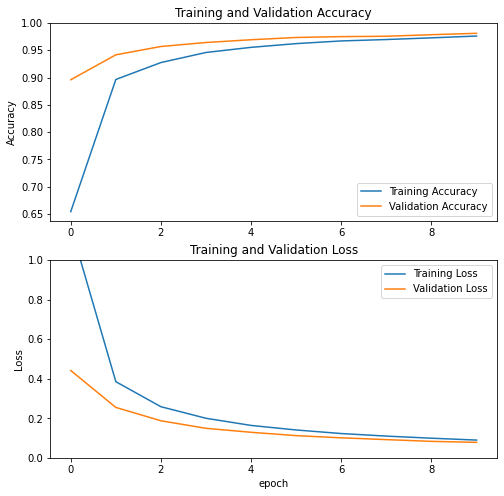

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning for better result

In [17]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [18]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [20]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
790/790 [==============================] - 66s 79ms/step - loss: 0.0651 - accuracy: 0.9781 - val_loss: 0.0399 - val_accuracy: 0.9867
Epoch 11/15
790/790 [==============================] - 61s 77ms/step - loss: 0.0335 - accuracy: 0.9897 - val_loss: 0.0302 - val_accuracy: 0.9889
Epoch 12/15
790/790 [==============================] - 63s 79ms/step - loss: 0.0189 - accuracy: 0.9947 - val_loss: 0.0156 - val_accuracy: 0.9949
Epoch 13/15
790/790 [==============================] - 61s 77ms/step - loss: 0.0131 - accuracy: 0.9965 - val_loss: 0.0156 - val_accuracy: 0.9962
Epoch 14/15
790/790 [==============================] - 61s 77ms/step - loss: 0.0081 - accuracy: 0.9980 - val_loss: 0.0098 - val_accuracy: 0.9975
Epoch 15/15
790/790 [==============================] - 63s 80ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.0091 - val_accuracy: 0.9968


In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

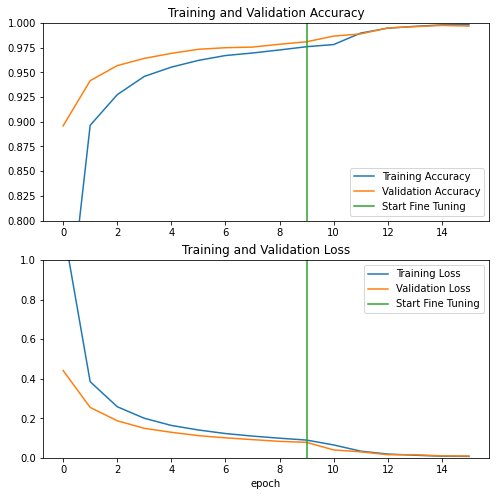

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test Model Performance with test set

In [23]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

99/99 [==============================] - 6s 57ms/step - loss: 0.0180 - accuracy: 0.9940
Test accuracy : 0.9940025210380554


Predictions:
 [1, 14, 14, 9, 7, 6, 12, 0, 13, 9, 12, 12, 10, 10, 2, 15, 12, 10, 13, 10, 8, 1, 2, 9, 3, 10, 1, 10, 0, 10, 15, 4]
Labels:
 [1, 14, 14, 9, 7, 6, 12, 0, 13, 9, 12, 12, 10, 10, 2, 15, 12, 10, 13, 10, 8, 1, 2, 9, 3, 10, 1, 10, 0, 10, 15, 4]


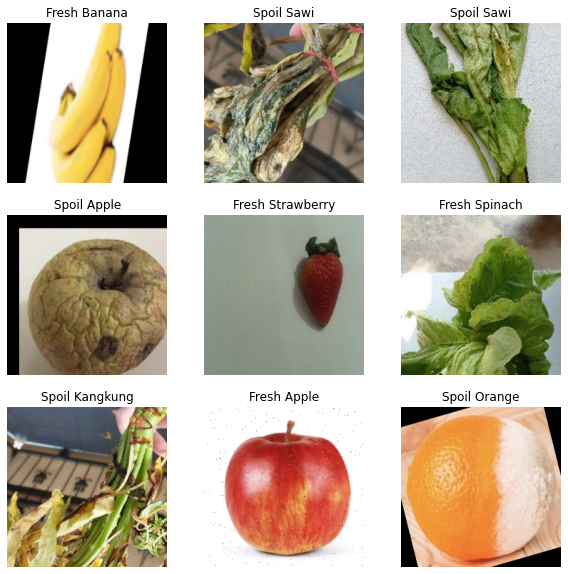

In [28]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

#Confusion matrix

In [29]:
print(len(test_dataset))

99


In [30]:
y_pred = np.array([])
y_true =  np.array([])
for x, y in test_dataset:
  y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis = -1)])
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

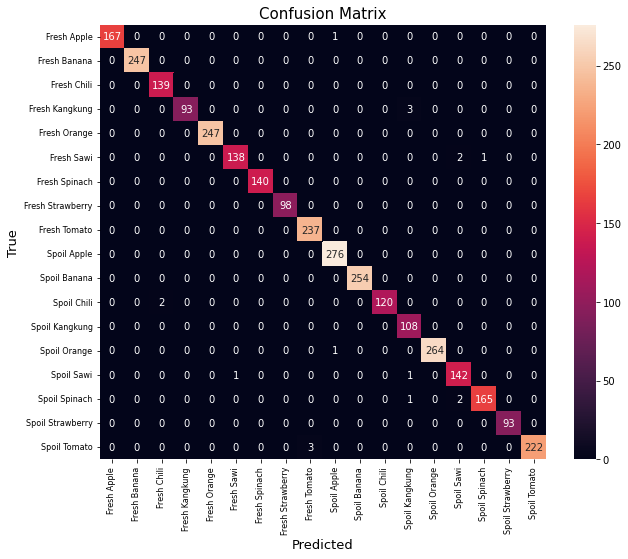

In [31]:
cm = confusion_matrix(y_true, y_pred)

fig = plt.figure(figsize=(10, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

ax.set_xlabel('Predicted', fontsize=13)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 8)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=13)
ax.yaxis.set_ticklabels(class_names, fontsize = 8)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat.png')
plt.show()

#Try Model With Custom Single Image

In [46]:
img = image.load_img(path='/content/sTom2.JPG', target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
result = model.predict(img)
print(np.round_(result*100, decimals=2))

y_pred = np.argmax(result, axis=1)
print(y_pred)
if y_pred[0] == 0:
    print("Fresh Apple")
elif y_pred[0] == 1:
    print("Fresh Banana")
elif y_pred[0] == 2:
    print("Fresh Chilli")
elif y_pred[0] == 3:
    print("Fresh Kangkung")
elif y_pred[0] == 4:
    print("Fresh Orange")
elif y_pred[0] == 5:
    print("Fresh Sawi")
elif y_pred[0] == 6:
    print("Fresh Spinach")
elif y_pred[0] == 7:
    print("Fresh Strawberry")
elif y_pred[0] == 8:
    print("Fresh Tomato")
elif y_pred[0] == 9:
    print("Spoil Apple")
elif y_pred[0] == 10:
    print("Spoil Banana")
elif y_pred[0] == 11:
    print("Spoil Chili")
elif y_pred[0] == 12:
    print("Spoil Kangkung")
elif y_pred[0] == 13:
    print("Spoil Orange")
elif y_pred[0] == 14:
    print("Spoil Sawi")
elif y_pred[0] == 15:
    print("Spoil Spinach")
elif y_pred[0] == 16:
    print("Spoil Strawberry")
elif y_pred[0] == 17:
    print("Spoil Tomato")

[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 2.00e-02 4.00e-02 0.00e+00 0.00e+00 3.00e-02 0.00e+00 0.00e+00
  0.00e+00 9.99e+01]]
[17]
Spoil Tomato


#Save Model

In [47]:
model.save('/content/Model_18X_Class_Acc99.h5')